In [1]:
import tqdm
import pandas as pd 
import numpy as np 
import os
from itertools import chain
from sklearn.model_selection import train_test_split

In [2]:
import tensorflow as tf

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

In [4]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_visible_devices(gpus[0], 'GPU') 
        print(gpus[0].name)
    except RuntimeError as e:
        print(e)

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

In [6]:
img_labels_df = pd.read_csv('data/image_labels.csv')

img_labels_df

,img_name,diagnosis,follow_up_num,patient_id,patient_age,patient_gender,view_position,original_width,original_height,original_x_spacing,original_y_spacing
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168
...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,38,M,PA,2048,2500,0.168,0.168
112116,00030802_000.png,No Finding,0,30802,28,M,PA,2048,2500,0.168,0.168
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,0.168
112118,00030804_000.png,No Finding,0,30804,29,F,PA,2048,2500,0.168,0.168


In [7]:
img_labels_df['split_diagnoses'] = img_labels_df.apply(lambda x: x['diagnosis'].split('|'), axis=1)
img_labels_df = img_labels_df[img_labels_df['split_diagnoses'].apply(lambda x: len(x) == 1)]
no_finding_df = img_labels_df[img_labels_df['diagnosis'] == 'No Finding']
no_finding_df.shape
no_findings_rows_to_drop = no_finding_df.sample(frac=0.85).index
img_labels_df = img_labels_df.drop(no_findings_rows_to_drop)

In [ ]:
class_counts = img_labels_df['diagnosis'].value_counts()
classes_to_drop = class_counts[class_counts < 1000].index.tolist()
img_labels_df = img_labels_df[~img_labels_df['diagnosis']].isin(classes_to_drop)]

In [8]:
all_diagnoses = list(set(chain(*img_labels_df['diagnosis'].map(lambda x: x.split('|')).tolist())))
for diagnosis in all_diagnoses:
    img_labels_df[diagnosis] = img_labels_df['diagnosis'].map(lambda diagnoses: diagnosis in diagnoses)

diagnosis_counts = {diagnosis: img_labels_df[diagnosis].sum() for diagnosis in all_diagnoses}

print(f"Dataframe Shape: {img_labels_df.shape}")
img_labels_df.head(10)

Dataframe Shape: (40017, 27)


,img_name,diagnosis,follow_up_num,patient_id,patient_age,patient_gender,view_position,original_width,original_height,original_x_spacing,...,Pneumonia,Pneumothorax,Emphysema,No Finding,Edema,Infiltration,Cardiomegaly,Fibrosis,Pleural_Thickening,Effusion
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,...,False,False,False,False,False,False,True,False,False,False
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,...,False,False,False,False,False,False,False,False,False,False
5,00000003_002.png,Hernia,1,3,75,F,PA,2048,2500,0.168,...,False,False,False,False,False,False,False,False,False,False
7,00000003_004.png,Hernia,3,3,77,F,PA,2500,2048,0.168,...,False,False,False,False,False,False,False,False,False,False
8,00000003_005.png,Hernia,4,3,78,F,PA,2686,2991,0.143,...,False,False,False,False,False,False,False,False,False,False
9,00000003_006.png,Hernia,5,3,79,F,PA,2992,2991,0.143,...,False,False,False,False,False,False,False,False,False,False
10,00000003_007.png,Hernia,6,3,80,F,PA,2582,2905,0.143,...,False,False,False,False,False,False,False,False,False,False
11,00000003_000.png,Hernia,7,3,81,F,PA,2582,2991,0.143,...,False,False,False,False,False,False,False,False,False,False
19,00000005_006.png,Infiltration,6,5,70,F,PA,2992,2991,0.143,...,False,False,False,False,False,True,False,False,False,False
23,00000008_000.png,Cardiomegaly,0,8,68,F,PA,2048,2500,0.171,...,False,False,False,False,False,False,True,False,False,False


In [9]:
img_labels_df['vectorized_diagnoses'] = img_labels_df.apply(lambda x: [x[all_diagnoses].values], 1).map(lambda x: [float(val) for val in x[0]])
img_labels_df["img_path"] = img_labels_df['img_name'].apply(lambda x: "./data/images/" + x)

In [10]:
split: list[pd.DataFrame] = train_test_split(img_labels_df, test_size=0.15, random_state=2003)
training_df, validation_df = split
print(f"Training Size: {len(training_df)}\nValidation Size: {len(validation_df)}")

Training Size: 34014
Validation Size: 6003


In [11]:
training_df.sample(10)

,img_name,diagnosis,follow_up_num,patient_id,patient_age,patient_gender,view_position,original_width,original_height,original_x_spacing,...,Emphysema,No Finding,Edema,Infiltration,Cardiomegaly,Fibrosis,Pleural_Thickening,Effusion,vectorized_diagnoses,img_path
52981,00013361_000.png,Atelectasis,0,13361,41,M,PA,2992,2991,0.143,...,False,False,False,False,False,False,False,False,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",./data/images/00013361_000.png
47875,00012141_008.png,Effusion,7,12141,31,M,AP,2500,2048,0.168,...,False,False,False,False,False,False,False,True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",./data/images/00012141_008.png
73937,00018186_014.png,Infiltration,14,18186,42,M,PA,2730,2991,0.143,...,False,False,False,True,False,False,False,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",./data/images/00018186_014.png
76741,00018860_006.png,No Finding,4,18860,36,M,AP,2500,2048,0.168,...,False,True,False,False,False,False,False,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",./data/images/00018860_006.png
35399,00009342_004.png,Atelectasis,4,9342,53,F,AP,2500,2048,0.168,...,False,False,False,False,False,False,False,False,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",./data/images/00009342_004.png
88611,00021955_000.png,Infiltration,0,21955,55,F,PA,2500,2048,0.168,...,False,False,False,True,False,False,False,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",./data/images/00021955_000.png
7885,00002063_000.png,No Finding,0,2063,37,F,PA,2048,2500,0.171,...,False,True,False,False,False,False,False,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",./data/images/00002063_000.png
11323,00002976_000.png,Infiltration,0,2976,52,M,PA,2500,2048,0.171,...,False,False,False,True,False,False,False,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",./data/images/00002976_000.png
66892,00016525_003.png,Effusion,3,16525,72,F,PA,2992,2991,0.143,...,False,False,False,False,False,False,False,True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",./data/images/00016525_003.png
94550,00024299_000.png,Atelectasis,2,24299,49,M,PA,2992,2991,0.143,...,False,False,False,False,False,False,False,False,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",./data/images/00024299_000.png


In [12]:
validation_df.sample(10)

,img_name,diagnosis,follow_up_num,patient_id,patient_age,patient_gender,view_position,original_width,original_height,original_x_spacing,...,Emphysema,No Finding,Edema,Infiltration,Cardiomegaly,Fibrosis,Pleural_Thickening,Effusion,vectorized_diagnoses,img_path
62894,00015556_002.png,Emphysema,2,15556,56,M,AP,2500,2048,0.168,...,True,False,False,False,False,False,False,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",./data/images/00015556_002.png
94816,00024542_000.png,No Finding,0,24542,33,M,PA,2048,2500,0.168,...,False,True,False,False,False,False,False,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",./data/images/00024542_000.png
77514,00019049_000.png,No Finding,4,19049,55,M,PA,2992,2991,0.143,...,False,True,False,False,False,False,False,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",./data/images/00019049_000.png
17347,00004656_001.png,Pneumothorax,1,4656,44,M,AP,2500,2048,0.171,...,False,False,False,False,False,False,False,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",./data/images/00004656_001.png
56188,00014006_014.png,Nodule,14,14006,46,M,PA,2500,2048,0.168,...,False,False,False,False,False,False,False,False,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",./data/images/00014006_014.png
41232,00010677_037.png,Pleural_Thickening,37,10677,55,F,AP,2500,2048,0.168,...,False,False,False,False,False,False,True,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",./data/images/00010677_037.png
79702,00019576_048.png,Infiltration,48,19576,48,M,AP,2500,2048,0.168,...,False,False,False,True,False,False,False,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",./data/images/00019576_048.png
80732,00019832_000.png,Infiltration,0,19832,32,F,PA,2992,2991,0.143,...,False,False,False,True,False,False,False,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",./data/images/00019832_000.png
47244,00012021_025.png,Infiltration,26,12021,24,M,AP,2500,2048,0.168,...,False,False,False,True,False,False,False,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",./data/images/00012021_025.png
5267,00001398_000.png,No Finding,0,1398,48,F,PA,2048,2500,0.171,...,False,True,False,False,False,False,False,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",./data/images/00001398_000.png


In [13]:
idg_parameterized = ImageDataGenerator(height_shift_range= 0.07,
                                  width_shift_range=0.12,
                                  rotation_range=5,
                                  zoom_range=0.17,
                                  shear_range = 0.12,
                                  horizontal_flip = True,
                                  vertical_flip = False,
                                  samplewise_center=True, 
                                  samplewise_std_normalization=True, 
                                  fill_mode = 'reflect',
                                )
img_dimensions = (128, 128)

In [14]:
training_gen = idg_parameterized.flow_from_dataframe(dataframe=training_df, 
                             directory=None,
                             x_col = "img_path",
                            y_col = 'split_diagnoses', 
                             class_mode = 'categorical',
                            classes = all_diagnoses,
                            target_size = img_dimensions,
                             color_mode = 'rgb',
                            batch_size = 32)

Found 34014 validated image filenames belonging to 15 classes.


In [15]:
validation_gen = idg_parameterized.flow_from_dataframe(dataframe=validation_df, 
                            directory=None,
                            x_col = 'img_path',
                            y_col = 'split_diagnoses', 
                            class_mode = 'categorical',
                            classes = all_diagnoses,
                            target_size = img_dimensions,
                            color_mode = 'rgb',
                            batch_size = 256)

Found 6003 validated image filenames belonging to 15 classes.


In [16]:
t_X, t_Y = next(idg_parameterized.flow_from_dataframe(dataframe=training_df, 
                             directory=None,
                             x_col = 'img_path',
                            y_col = 'split_diagnoses', 
                             class_mode = 'categorical',
                            classes = all_diagnoses,
                            target_size = img_dimensions,
                             color_mode = 'rgb',
                            batch_size = 1024))

Found 34014 validated image filenames belonging to 15 classes.


In [17]:
v_X, v_Y = next(idg_parameterized.flow_from_dataframe(dataframe=validation_df, 
                             directory=None,
                             x_col = 'img_path',
                            y_col = 'split_diagnoses', 
                             class_mode = 'categorical',
                            classes = all_diagnoses,
                            target_size = img_dimensions,
                             color_mode = 'rgb',
                            batch_size = 1024))

Found 6003 validated image filenames belonging to 15 classes.


In [18]:
print(len(t_X[0]))

128


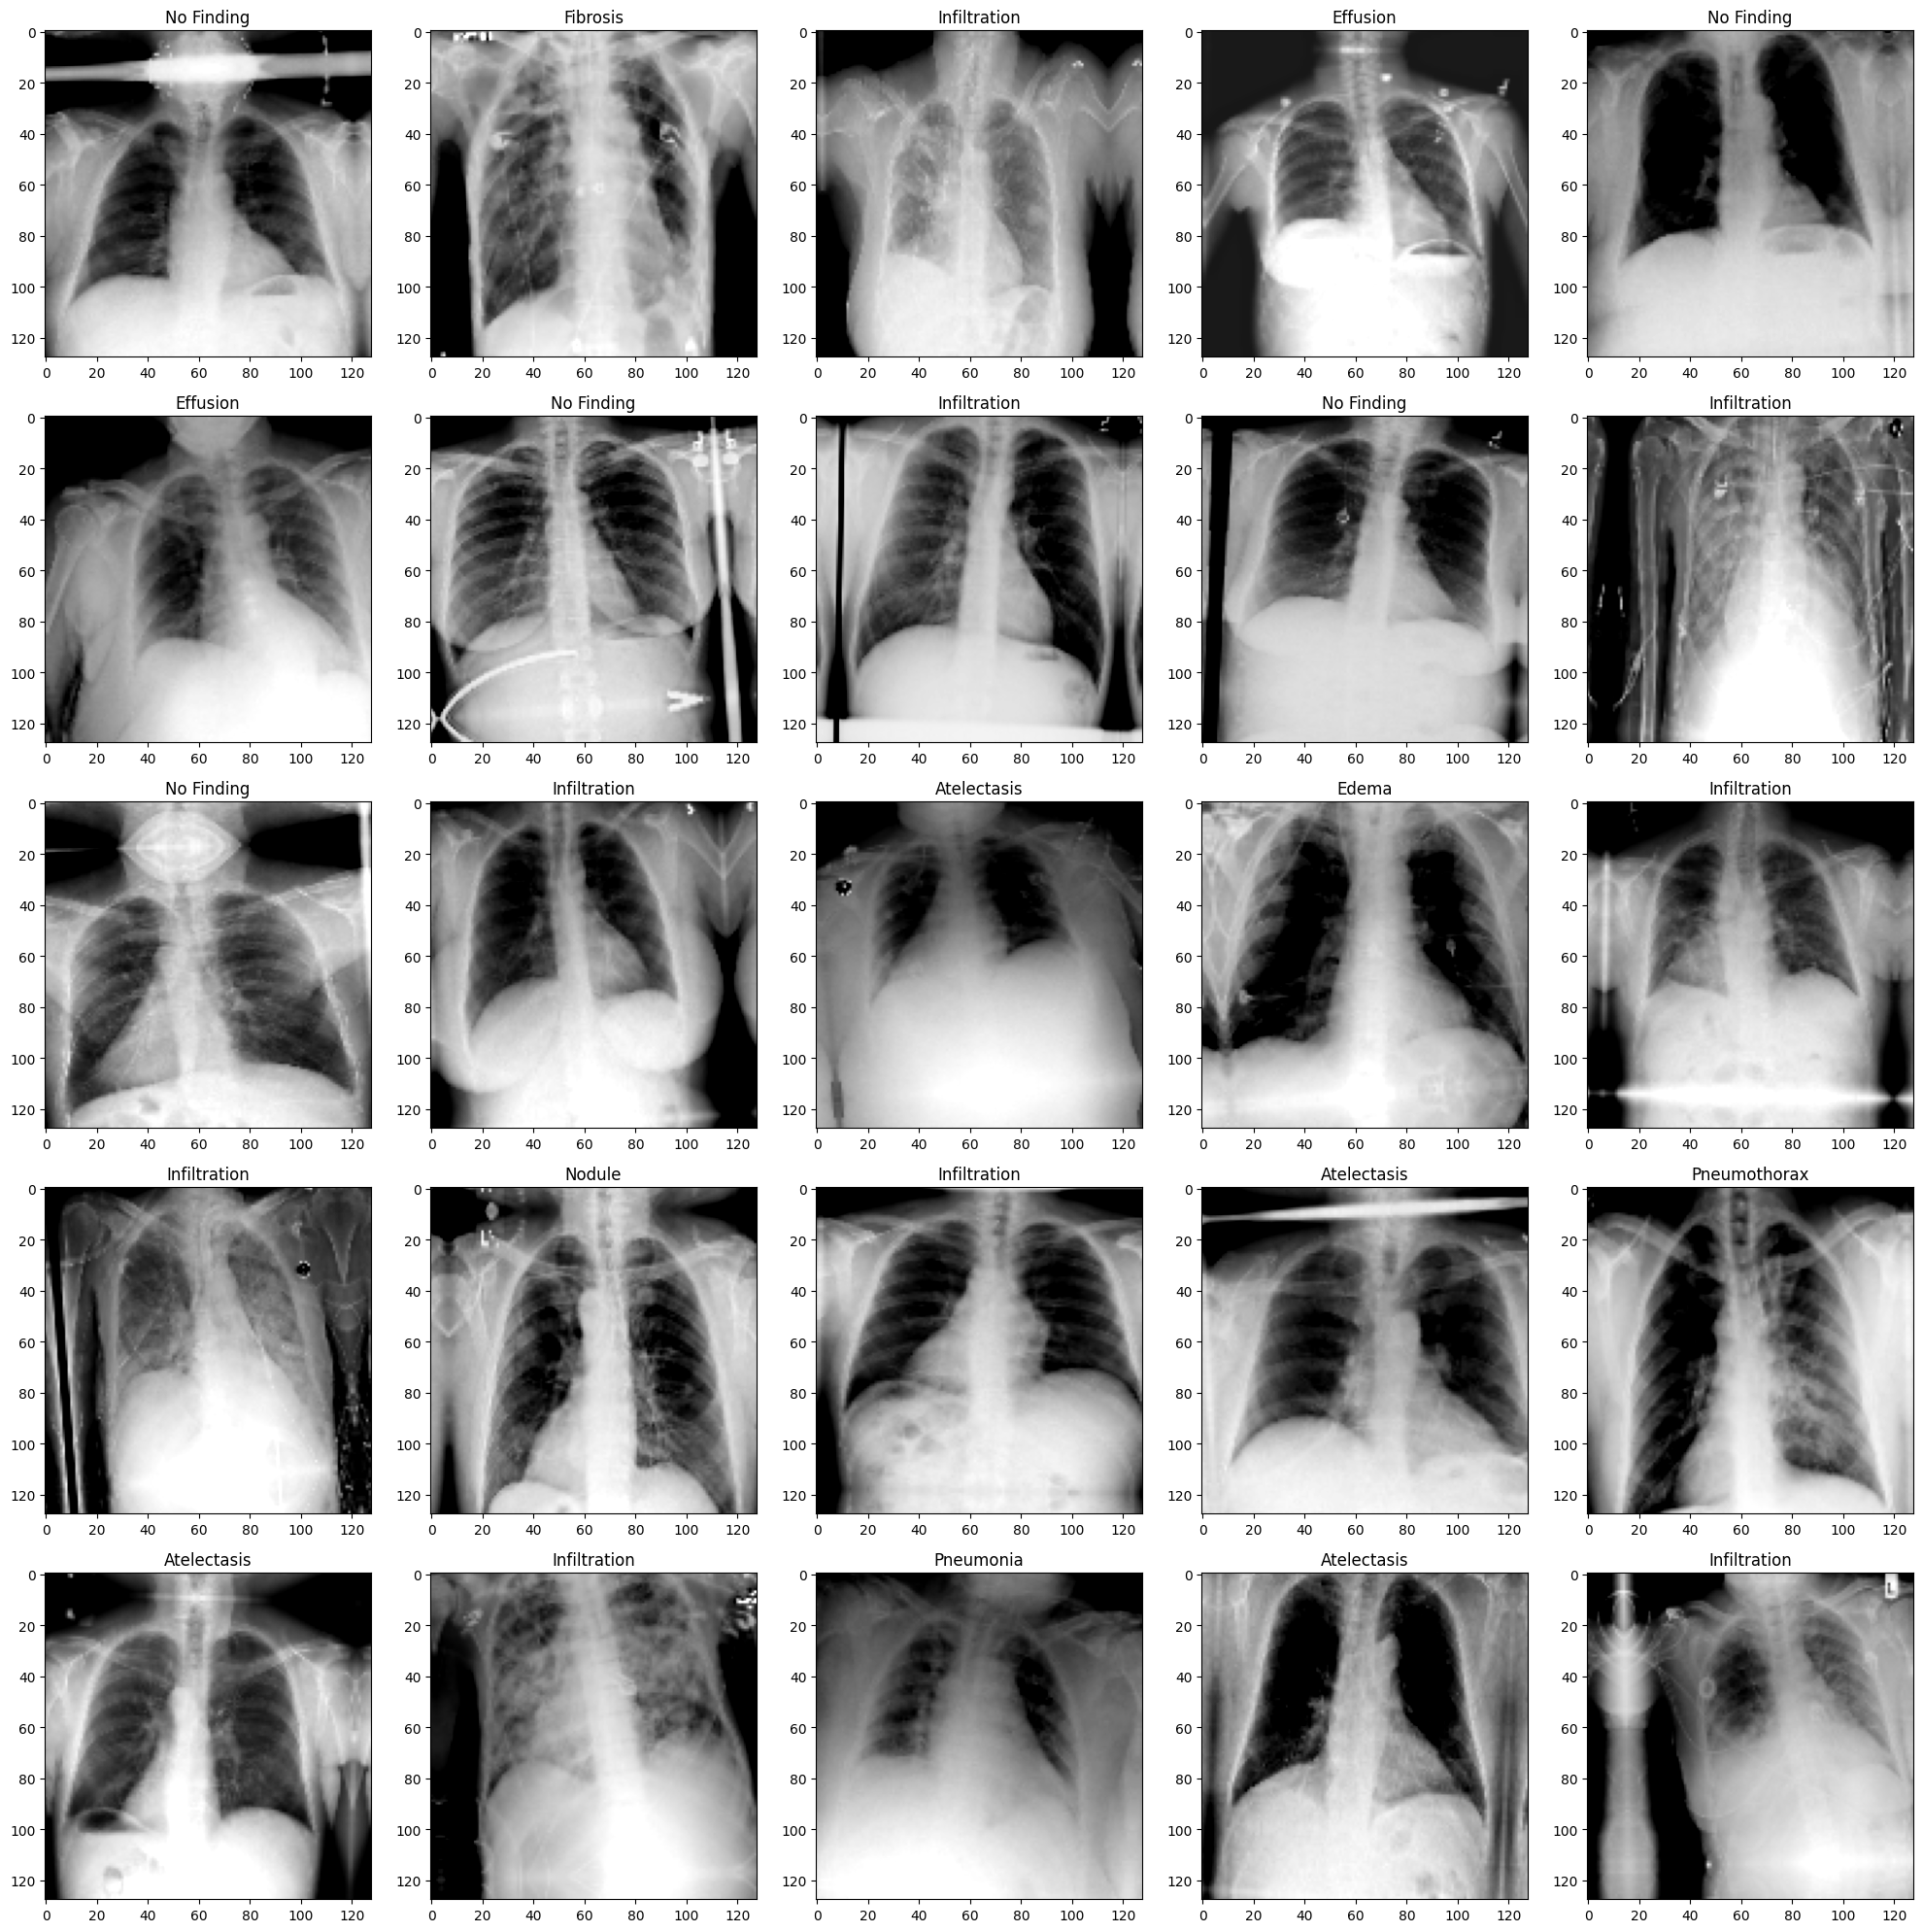

In [19]:
grid_size = 5

tr_x, tr_y = next(training_gen)

fig, matrix_axs = plt.subplots(grid_size, grid_size, figsize=(grid_size * 4, grid_size * 4))
for (img, labels, ax) in zip(tr_x, tr_y, matrix_axs.flatten()):
    ax.imshow(img[:, :, 0], cmap='gist_gray', vmin=-1.5, vmax=1.5)
    title = ', '.join([diagnosis for diagnosis, score in zip(all_diagnoses, labels) if score > 0.5])
    ax.set_title(title)

plt.tight_layout()
plt.show()

In [20]:
from tensorflow.keras.applications import VGG16

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False

58889256/58889256 [==============================] - 7s 0us/step


In [22]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Reshape, Dense, multiply, Input, Conv2D
from tensorflow.keras.models import Model

def squeeze_excite_block(input, ratio=16):
    init = input
    channel_axis = -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)
    
    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)
    
    x = multiply([init, se])
    return x

In [23]:
input_tensor = Input(shape=(128, 128, 3))

# Apply VGG base model
x = base_model(input_tensor)

# Apply the Squeeze and Excite block
x = squeeze_excite_block(x)

# Continue with custom layers
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(len(all_diagnoses), activation='softmax')(x)  # Output layer

# Construct the final model
model = Model(inputs=input_tensor, outputs=x)

In [27]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define callbacks
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-best.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

# Use the same callbacks as in v1
history = model.fit(
    training_gen,
    validation_data=validation_gen,
    epochs=1,
    callbacks=callbacks
)

1063/1063 [==============================] - ETA: 0s - loss: 2.1474 - accuracy: 0.2779
Epoch 1: val_loss improved from inf to 2.09838, saving model to model-best.h5
1063/1063 [==============================] - 1554s 1s/step - loss: 2.1474 - accuracy: 0.2779 - val_loss: 2.0984 - val_accuracy: 0.2834 - lr: 0.0010


In [28]:
test_loss, test_acc= model.evaluate(v_X, v_Y, verbose=2)
print(f'Test accuracy: {test_acc}\nTest loss: {test_loss}')

32/32 - 26s - loss: 2.0781 - accuracy: 0.2510 - 26s/epoch - 810ms/step
Test accuracy: 0.2509765625
Test loss: 2.0781357288360596


In [29]:
# Assuming X_test is your test set
predictions = model.predict(v_X)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(v_Y, axis=1)

32/32 [==============================] - 26s 816ms/step


In [30]:
from sklearn.metrics import classification_report, confusion_matrix

# Print classification report
print(classification_report(true_classes, predicted_classes, target_names=all_diagnoses))

# Generate and display confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

                    precision    recall  f1-score   support

              Mass       0.00      0.00      0.00        44
            Hernia       0.00      0.00      0.00         2
       Atelectasis       0.37      0.11      0.17       115
     Consolidation       0.00      0.00      0.00        35
            Nodule       0.00      0.00      0.00        67
         Pneumonia       0.00      0.00      0.00         7
      Pneumothorax       0.00      0.00      0.00        62
         Emphysema       0.00      0.00      0.00        27
        No Finding       0.31      0.24      0.27       254
             Edema       0.00      0.00      0.00        12
      Infiltration       0.22      0.67      0.33       221
      Cardiomegaly       0.00      0.00      0.00        23
          Fibrosis       0.00      0.00      0.00        20
Pleural_Thickening       0.00      0.00      0.00        31
          Effusion       0.34      0.32      0.33       104

          accuracy                    

c:\Users\cgarcia0\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\cgarcia0\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\cgarcia0\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
